# Simulated Annealing and Genetic Algorithm Presentation

Authors: Stefan-Claudiu Cristescu
         Luke Ryan
         Ridvan Karaman
         Xavier Gauchoux

# Generate random nodes

In [1]:
import random
import numpy as np

'''set the dimensions of the grid'''
size_width = 200
size_height = 200

'''set the number of nodes'''
population_size = 10

def generateNodes(width, height, nodesNumber):
    xs = np.random.randint(width, size=nodesNumber)
    ys = np.random.randint(height, size=nodesNumber)

    print('Nodes and coordinates:')
    print(np.column_stack((xs, ys)))
    return np.column_stack((xs, ys))

'''generate random list of nodes'''
nodes = generateNodes(size_width, size_height, population_size)


Nodes and coordinates:
[[132 183]
 [131 100]
 [ 76 113]
 [ 68  37]
 [188  18]
 [116  75]
 [101 196]
 [ 96  85]
 [188   5]
 [178  41]]


# Functions to calculate initial weight

In [2]:
import math


def vectorToDistMatrix(coords):
    '''
    Create the distance matrix
    '''
    return np.sqrt((np.square(coords[:, np.newaxis] - coords).sum(axis=2)))


def nearestNeighbourSolution(dist_matrix):
    '''
    Computes the initial solution (nearest neighbour strategy)
    '''
    node = random.randrange(len(dist_matrix))
    result = [node]

    nodes_to_visit = list(range(len(dist_matrix)))
    nodes_to_visit.remove(node)

    while nodes_to_visit:
        nearest_node = min([(dist_matrix[node][j], j) for j in nodes_to_visit], key=lambda x: x[0])
        node = nearest_node[1]
        nodes_to_visit.remove(node)
        result.append(node)

    return result


# Bruteforce implementation (gets the most optim path)

In [3]:
from itertools import permutations
from datetime import datetime

def get_best_score_brute_force(nodes_matrix, paths):
    best_score = 0
    best_solution = []

    for path in paths:
        score = 0

        for i in range(1, len(path)):
            score += nodes_matrix[path[i-1]][path[i]]

        score += nodes_matrix[path[-1]][path[0]]

        if best_score == 0 or score < best_score:
            best_score = score
            best_solution = path

    return (best_score, best_solution)

bruteforce_start_ts = datetime.now()
nodes_matrix = vectorToDistMatrix(nodes)
all_permutations = list(permutations(range(len(nodes_matrix[0]))))
bf_result = get_best_score_brute_force(nodes_matrix, all_permutations)
bruteforce_precessing_time = (datetime.now() - bruteforce_start_ts).total_seconds()

print("Bruteforce results:")
print("\tBest score:", bf_result[0])
print("\tBest path: ", bf_result[1])
print("\tExecution time:", bruteforce_precessing_time, "seconds")

Bruteforce results:
	Best score: 555.4226128337092
	Best path:  (0, 1, 5, 9, 4, 8, 3, 7, 2, 6)
	Execution time: 25.028087 seconds


# Class for simulated annealing

In [4]:
import math
import matplotlib.pyplot as plt


class SimulatedAnnealing:
    def __init__(self, coords, temp, alpha, stopping_temp, stopping_iter):
        ''' animate the solution over time

            Parameters
            ----------
            coords: array_like
                list of coordinates
            temp: float
                initial temperature
            alpha: float
                rate at which temp decreases
            stopping_temp: float
                temerature at which annealing process terminates
            stopping_iter: int
                interation at which annealing process terminates

        '''

        self.coords = coords
        self.sample_size = len(coords)
        self.temp = temp
        self.alpha = alpha
        self.stopping_temp = stopping_temp
        self.stopping_iter = stopping_iter
        self.iteration = 1

        self.dist_matrix = vectorToDistMatrix(coords)
        self.curr_solution = nearestNeighbourSolution(self.dist_matrix)
        self.best_solution = self.curr_solution

        self.solution_history = [self.curr_solution]

        self.curr_weight = self.weight(self.curr_solution)
        self.initial_weight = self.curr_weight
        self.min_weight = self.curr_weight

        self.weight_list = [self.curr_weight]

        print('Intial weight (nearest neighbour algorithm): ', self.curr_weight)

    def weight(self, sol):
        '''
        Calcuate weight
        '''
        return sum([self.dist_matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def acceptance_probability(self, candidate_weight):
        '''
        Acceptance probability as described in:
        https://stackoverflow.com/questions/19757551/basics-of-simulated-annealing-in-python
        '''
        return math.exp(-abs(candidate_weight - self.curr_weight) / self.temp)

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        candidate_weight = self.weight(candidate)
        if candidate_weight < self.curr_weight:
            self.curr_weight = candidate_weight
            self.curr_solution = candidate
            if candidate_weight < self.min_weight:
                self.min_weight = candidate_weight
                self.best_solution = candidate

        else:
            if random.random() < self.acceptance_probability(candidate_weight):
                self.curr_weight = candidate_weight
                self.curr_solution = candidate

    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            candidate = list(self.curr_solution)
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)

            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])

            self.accept(candidate)
            self.temp *= self.alpha
            self.iteration += 1
            self.weight_list.append(self.curr_weight)
            self.solution_history.append(self.curr_solution)

        print('Minimum weight (simulated annealing algorithm): ', self.min_weight)
        
        improvement_percent = round((self.initial_weight - self.min_weight) / (self.initial_weight), 4) * 100
        print('Improvement: ', improvement_percent, '%')
        print()
        print('Solution:', self.best_solution)
        
        return (self.min_weight, self.best_solution, improvement_percent)

    def plotLearning(self):
        plt.plot([i for i in range(len(self.weight_list))], self.weight_list)
        line_init = plt.axhline(y=self.initial_weight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.min_weight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        plt.show()

# Main code

Intial weight (nearest neighbour algorithm):  640.8670825249421
Minimum weight (simulated annealing algorithm):  555.4226128337092
Improvement:  13.33 %

Solution: [2, 6, 0, 1, 5, 9, 4, 8, 3, 7]
Execution time: 0.385967 seconds


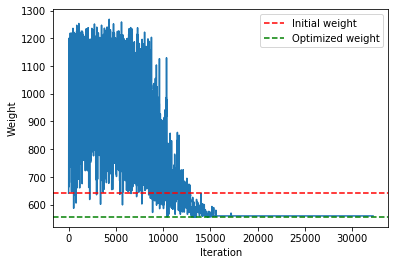

In [5]:
'''set the simulated annealing algorithm params'''
temperature = 10000
stopping_temp = 0.001
alpha = 0.9995
stopping_iter = 20000000

'''run simulated annealing algorithm with 2-opt'''
sa = SimulatedAnnealing(nodes, temperature, alpha, stopping_temp, stopping_iter)
annealing_start_ts = datetime.now()
anneal_results = sa.anneal()
annealing_precessing_time = (datetime.now() - annealing_start_ts).total_seconds()
print("Execution time:", annealing_precessing_time, "seconds")

'''show the improvement over time'''
sa.plotLearning()    

# Statistics

In [6]:
print("Bruteforce results:")
print("\tBest score:", bf_result[0])
print("\tExecution time:", bruteforce_precessing_time, "seconds")

print()

print("Simulated Annealing results:")
print("\tBest score:", anneal_results[0])
print("\tBest path: ", anneal_results[1])
print("\tExecution time:", annealing_precessing_time, "seconds")

print()

print("Simulated annealing is better than nearest neighbour algorithm by", anneal_results[2], "%")
print("Simulated annealing is less acurate than brute force algorithm by", 
      round((anneal_results[0] - bf_result[0]) / (anneal_results[0]), 4) * 100, "%")

Bruteforce results:
	Best score: 555.4226128337092
	Execution time: 25.028087 seconds

Simulated Annealing results:
	Best score: 555.4226128337092
	Best path:  [2, 6, 0, 1, 5, 9, 4, 8, 3, 7]
	Execution time: 0.385967 seconds

Simulated annealing is better than nearest neighbour algorithm by 13.33 %
Simulated annealing is less acurate than brute force algorithm by 0.0 %


# Simulated Annealing Pseudocode

```C
currentSolution <- create_initial_solution()
bestSolution <- create_initial_solution()
for i <- 1,…,iterationMax do
	S[i] <- create_neighbor_solution (currentSolution)
	currentTemperature <- calculate_temperature (i)
	if weight(S[i]) < weight(currentSolution) then
		currentSolution <- S[i]
		if weight(S[i]) < weight(bestSolution) then
			bestSolution <- S[i]
		end if
	else if exp(-abs(S[i] - currentSolution) / currentTemperature) > rand() then
		currentSolution <- S[i]
	end if
end for
return bestSolution
```

# BIG O: Simulated Annealing

`O((N^2 + N)*log N))`

# Definition

The simulated annealing algorithm is a method of optimisation which is based on the real-life model of the slow cooling of metal. This process is called annealing, which is characterised by the atomic movement steadily lowering to reduce the defects in the metal until a lowest-energy state is attained. If molten hot metal were to be instantly lowered to a very cold temperature this would cause lots of defects and inconsistences in the metal.  However, if it is cooled with the annealing method then the metal will become very strong and stable. (Sciencedirect.com. 2020)
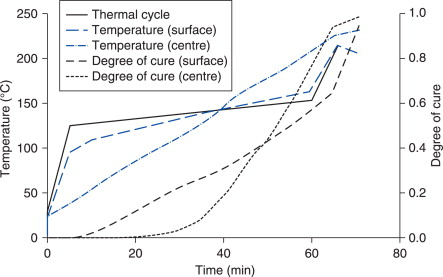

# Advantages

A greedy algorithm will always choose the nearest neighbour, which will produce a sub-optimal route. These routes can be improved by using opt swap; selecting two edges and reconnecting them to produce a new route. Using local search, the current optimal solution can be improved continuously. Although due to early selections by the greedy algorithm the outputted optimal solution can be much more efficient but still sub-optimal, due getting stuck in a sub-optimal configuration. This is called local minimum. Some techniques such as the simulated annealing algorithm can avoid this by probabilistically accepting worse solutions early in the search process. (Coddington, P., 2020)

# Explanation

The search lifespan in simulated annealing is measured by its ‘temperature’. At the beginning of the search process it is ‘hot’ and more readily accepts worse solutions. As the temperature drops lower the algorithm is less likely to accept new solutions which are worse. (Walker, J., 2018)
Explore nearest neighbours in order to find an optimal solution. If there is a more optimal solution by moving to a neighbour, then always move to that neighbour.  If there is a less optimal solution by moving to a neighbour, then move with a certain degree of probability, which steadily decreases over time. When the algorithm is finished it will output the approximate optimal solution. Neighbours can be changed due to something called triangle inequality. Which basically means that the distance between d(x,y) <= d(x,z) + d(z,y). Essentially the route directly from x to y is always shorter than any other route. (Nikolaev A.G., Jacobson S.H., 2010)
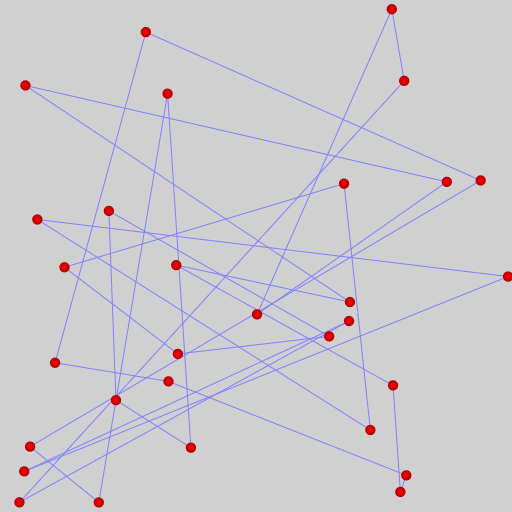
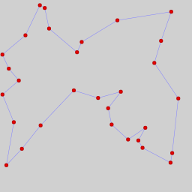


# Hill Climbing Example

A good example of this algorithm in use is making a program to check for the highest point on a hill. It is not resource or time efficient to check every point on the hill, so instead the current state will check each of its nearest neighbours. The algorithm will check to the left and the right and go to the highest neighbour. An issue with this if there’s a slight dip before an even higher point on the hill, the algorithm will not go beyond the dip, since it is lower than the current highest point. The state gets stuck at these points which are called local maxima. A way to overcome this issue is to try and select a worse neighbour with the hope of eventually finding a better neighbour, or the global maxima. This method involves selecting worse neighbours with a certain degree of probability. By selecting neighbours based on how close they are in height to the current state the algorithm can explore nearby neighbours to find a much more optimal state. 
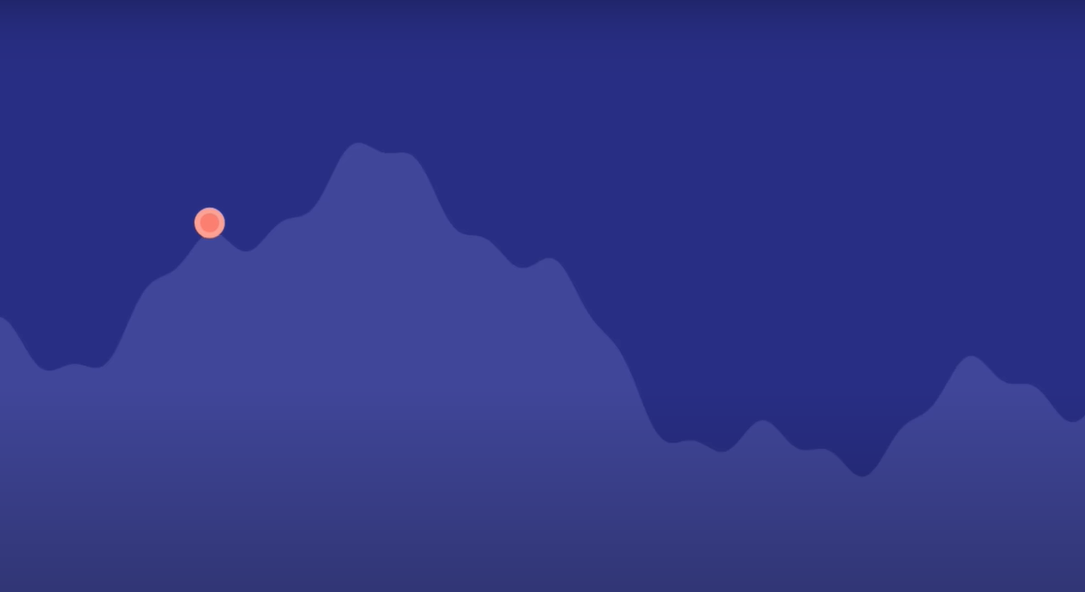

# References

Sciencedirect.com. 2020. Simulated Annealing Algorithm - An Overview | Sciencedirect Topics. [online] Available at: <https://www.sciencedirect.com/topics/engineering/simulated-annealing-algorithm> [Accessed 10 March 2020]. 
Coddington, P., 2020. Simulated Annealing. [online] New-npac.org. Available at: <http://www.new-npac.org/projects/cdroms/cewes-1999-06-vol1/cps615course/csematerials/applications/mc/montecarlo/node134.html#SECTION000141000000000000000> [Accessed 13 March 2020].
Walker, J., 2018. Simulated Annealing: The Travelling Salesman Problem. [online] Fourmilab.ch. Available at: <https://www.fourmilab.ch/documents/travelling/anneal/> [Accessed 10 March 2020].
Nikolaev A.G., Jacobson S.H. (2010) Simulated Annealing. In: Gendreau M., Potvin JY. (eds) Handbook of Metaheuristics. International Series in Operations Research & Management Science, vol 146. Springer, Boston, MA [online] Available at: <https://doi.org/10.1007/978-1-4419-1665-5_1> [Accessed 6 March 2020].



# Genetic Algorithm

# Generate a random symmetric or euclidean graph

Given for the task

In [7]:
from random import randint, choice, shuffle, random
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from time      import time
import matplotlib.pyplot as plt
import copy
import numpy as np

MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    points = []
    for p in range(n):
        x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
        points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c

J = random_euclidean_graph(5)
G = random_symmetric_graph(5)
show(J)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞38.47076812334269115.2779250333731586.8331733843696477.4919350642375
 1 | 38.47076812334269   ∞79.6303962064738258.5491246732177955.57877292636101
 2 | 115.2779250333731579.63039620647382   ∞38.6393581727233154.91812087098393
 3 | 86.8331733843696458.5491246732177938.63935817272331   ∞16.278820596099706
 4 | 77.491935064237555.5787729263610154.9181208709839316.278820596099706   ∞

        0   1   2   3   4
    ---------------------
 0 |    ∞  86  57  93  17
 1 |   86   ∞  98   3  26
 2 |   57  98   ∞  49  45
 3 |   93   3  49   ∞  49
 4 |   17  26  45  49   ∞



# Create a generation of x possible routes

With a given graph, randomly generate a 'population' of possible routes

Code

In [8]:
G = random_symmetric_graph(5)
population = 6
print("\nMatrice")
show(G)

'''Used the shuffle function to generate a 'population' sized amount'''
'''of possible routes'''

def createGen(matrix, population):
    route = []
    genZ = [None] * int(population)
    for i in range(0,len(matrix)):
        route.append(i)
    for j in range(0,int(population)):
        if j == 0:
            np.random.shuffle(route)
            newRoute = route[:]
            genZ[j] = newRoute
        else:
            np.random.shuffle(route)
            for h in range(0,len(genZ)):
                if route == genZ[h]:
                    np.random.shuffle(route)
            newRoute = route[:]
            genZ[j] = newRoute
    return genZ

print("Genenration 0 of routes")        
print(createGen(G,6))


Matrice
        0   1   2   3   4
    ---------------------
 0 |    ∞  38  54  33  66
 1 |   38   ∞  16  21  83
 2 |   54  16   ∞  92  99
 3 |   33  21  92   ∞  52
 4 |   66  83  99  52   ∞

Genenration 0 of routes
[[1, 3, 4, 2, 0], [3, 1, 0, 4, 2], [0, 2, 1, 4, 3], [0, 2, 1, 3, 4], [3, 4, 0, 2, 1], [3, 4, 0, 1, 2]]


# Calculate the length of these routes

We use the values in the graph to create a new list of positiv integer which represents, for each route, the sum of all its edges cost for a loop (TSP), the travelling distance.

Code

In [9]:
def fitness(matrix, routes):
    fitnessRanking = []
    for i in range(0, len(routes)):
        fitnessTotal = 0
        for j in range(0,len(matrix)):
            if j + 1 < len(matrix):
                fitnessTotal = fitnessTotal + int(matrix[routes[i][j]][routes[i][j+1]])
            else:
                fitnessTotal = fitnessTotal + int(matrix[routes[i][j]][routes[i][0]])
        fitnessRanking.append(fitnessTotal)
    return fitnessRanking

show(G)
print("Genenration 0")        
genZ = createGen(G,6)
print(genZ)
print("Fitness")
ranking = fitness(G, genZ)
print(ranking)

        0   1   2   3   4
    ---------------------
 0 |    ∞  38  54  33  66
 1 |   38   ∞  16  21  83
 2 |   54  16   ∞  92  99
 3 |   33  21  92   ∞  52
 4 |   66  83  99  52   ∞

Genenration 0
[[1, 0, 2, 4, 3], [4, 0, 2, 3, 1], [4, 2, 3, 1, 0], [0, 1, 4, 3, 2], [1, 2, 4, 3, 0], [1, 3, 0, 4, 2]]
Fitness
[264, 316, 316, 319, 238, 235]


# Choose the parents for mating with Elitism

We then find the two routes with the lowest traveling distance by copying and sorting the rank list into a new list to find the top two.
Then we find the position of them in the ranking list and in so in the routes list

Code

In [10]:
def first(ranking, routes):
    sortedRank = ranking[:]
    sortedRank.sort()
    firstPos = ranking.index(sortedRank[0])
    firstRoute = routes[firstPos]
    return firstRoute

def second(ranking, routes):
    sortedRank = ranking[:]
    sortedRank.sort()
    secondPos = ranking.index(sortedRank[1])
    secondRoute = routes[secondPos]
    return secondRoute
    
win = first(ranking, genZ)
print(win)
win2 = second(ranking, genZ)
print(win2)
    

[1, 3, 0, 4, 2]
[1, 2, 4, 3, 0]


# Breeding

We then breed the those two routes together to create a whole new generation of routes.
To do so we take a random segment of random lentgh of the first parent and then put into the child (same segment in same position).
Then we fill in from next index in the child with the second parents nodes.

Code

In [11]:
def breed(parent1, parent2, population):
    nextGen = []
    
    for i in range(0,population):
        child = []
        childP1 = []
        childP2 = []
    
    
        geneA = int(np.random.random() * len(parent1))
        geneB = int(np.random.random() * len(parent1))
    
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)
    
        for i in range(startGene, endGene):
            childP1.append(parent1[i])
        
        childP2 = [item for item in parent2 if item not in childP1]
        child = childP1 + childP2
        nextGen.append(child)
    
    return nextGen
    
nextGen = breed(win, win2, population)
print(nextGen)

[[0, 1, 2, 4, 3], [1, 3, 2, 4, 0], [1, 3, 2, 4, 0], [0, 1, 2, 4, 3], [0, 1, 2, 4, 3], [0, 4, 1, 2, 3]]


# Mutation

We also randomly mutate each child route with a decided rate.
We apply it to a whole gen to make it easier.

Code

In [12]:
'''Mutation rate set to 5%'''

mutation = 0.05

def mutate(child, mutationRate):
    for swapped in range(len(child)):
        if(np.random.random() <= mutationRate):
            swapWith = int(np.random.random() * len(child))
            
            node1 = child[swapped]
            node2 = child[swapWith]
            
            child[swapped] = node2
            child[swapWith] = node1
    return child

def mutateGen(currentGen, mutationRate, population):
    mutatedGen = []
    
    for child in range(0, population):
        mutatedChild = mutate(currentGen[child], mutationRate)
        mutatedGen.append(mutatedChild)
        
    return mutatedGen

mutatedGen = mutateGen(nextGen,mutation, population)
print(mutatedGen)

[[0, 1, 2, 4, 3], [1, 3, 2, 4, 0], [1, 3, 2, 4, 0], [0, 1, 2, 4, 3], [1, 0, 2, 4, 3], [0, 4, 1, 2, 3]]


# Repeat

A function to be able to repeat this whole cycle of ranking, breeding and mutating to create a new generation

Code

In [13]:

def nextGeneration(mutatedGen, population, mutationRate):
    rank = fitness(G, mutatedGen)
    parent1 = first(rank, mutatedGen)
    parent2 = second(rank, mutatedGen)
    currentGen = breed(parent1, parent2, population)
    nextGeneration = mutateGen(currentGen, mutationRate, population)
    return nextGeneration

print(nextGeneration(mutatedGen, population, mutation))

[[0, 1, 4, 2, 3], [1, 0, 2, 4, 3], [2, 4, 0, 1, 3], [0, 1, 2, 4, 3], [0, 1, 2, 4, 3], [0, 1, 2, 4, 3]]


# Evolution

Allows us to see the evolution of the routes after x generations, starting by showing us the first best route with its value and finishing by showing us the new best one.

Code

In [31]:
def geneticAlgorithm(population, matrix, mutationRate, generations):
    result = []
    gen = createGen(matrix, population)
    rank = fitness(matrix, gen)
    rank.sort()
    print("Initial best route: ")
    print(rank[0])
    initBestRouteVal = rank[0]
    bestRouteVal = initBestRouteVal
    print(first(rank, gen))
    initBestRoute = first(rank, gen)
    bestRoute = initBestRoute
    result.append(rank[0])
    
    for i in range(0, int(generations)):
        gen = nextGeneration(gen, population, mutationRate)
        rank = fitness(G, gen)
        rank.sort()
        result.append(rank[0])
        if rank[0] < bestRouteVal:
            bestRouteVal = rank[0]
            bestRoute = first(rank, gen)
            
    print("\nFinal best route: ")
    print(bestRouteVal)
    print(bestRoute)
    
    print("\nImprovement")
    print(round((initBestRouteVal - bestRouteVal) / (initBestRouteVal), 4) * 100, '%')
    
    return result

bestRoute = geneticAlgorithm(population, G, mutation, 10)

Initial best route: 
304
[5, 3, 6, 2, 4, 0, 1, 8, 9, 7]

Final best route: 
254
[7, 0, 5, 1, 8, 2, 6, 3, 4, 9]

Improvement
16.45 %


# Main Code

To test the whole code.
Can change values to see different effects.

MAX_DISTANCE
100

Matrix
        0   1   2   3   4   5   6   7   8   9
    -----------------------------------------
 0 |    ∞   6  94  33  36  75  63  13  34   7
 1 |    6   ∞  96  44  90  51  88  55  99  83
 2 |   94  96   ∞  18  42  38  92  85  40   9
 3 |   33  44  18   ∞  54  50  14  11   7  33
 4 |   36  90  42  54   ∞  74  53  42  37  66
 5 |   75  51  38  50  74   ∞  31  49  44  61
 6 |   63  88  92  14  53  31   ∞  95  72  19
 7 |   13  55  85  11  42  49  95   ∞  77  93
 8 |   34  99  40   7  37  44  72  77   ∞  45
 9 |    7  83   9  33  66  61  19  93  45   ∞


Population
10

Mutation in %
0.05

Amount of generations created
100

Running ------------------------

Initial best route: 
441
[7, 3, 9, 8, 2, 1, 0, 6, 5, 4]

Final best route: 
236
[9, 2, 1, 6, 3, 8, 5, 4, 0, 7]

Improvement
46.489999999999995 %

-----------------------

Improvement over Time Graph


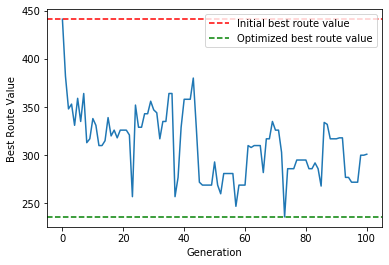

In [32]:
'''Inputs'''
'''Max distance between nodes in matrice'''
MAX_DISTANCE = 100
'''Select number of nodes wanted in the type of matrice wanted'''
'''G = random_euclidean_graph(15)'''
G = random_symmetric_graph(10)
'''Choose the population of travelers, amount of routes in a generation'''
population = 10
'''Mutation rate between 0 and 1'''
mutation=0.05
'''Number of generations wanted'''
generations = 100


print("MAX_DISTANCE")
print(MAX_DISTANCE)

print("\nMatrix")
show(G)

print("\nPopulation")
print(population)

print("\nMutation in %")
print(mutation)

print("\nAmount of generations created")
print(generations)

print("\nRunning ------------------------\n")
genetic_start_ts = datetime.now()
genetic_results = geneticAlgorithm(population, G, mutation, generations)
genetic_processing_time = (datetime.now() - genetic_start_ts).total_seconds()

print("\n-----------------------\n")

print("Improvement over Time Graph")


def graph(results):
    bestRoute = results[:]
    bestRoute.sort()
    bestRoute = bestRoute[0]
    genList = []
    for i in range(0,len(results)):
        genList.append(i)
    plt.plot(genList, results)
    line_init = plt.axhline(y=results[0], color='r', linestyle='--')
    line_min = plt.axhline(y=bestRoute, color='g', linestyle='--')
    plt.legend([line_init, line_min], ['Initial best route value', 'Optimized best route value'])
    plt.ylabel('Best Route Value')
    plt.xlabel('Generation')
    plt.show()
    
graph(genetic_results)
    

# Bruteforce Implementation for stats

In [24]:
from itertools import permutations
from datetime import datetime

def get_best_score_brute_force(nodes_matrix, paths):
    best_score = 0
    best_solution = []

    for path in paths:
        score = 0

        for i in range(1, len(path)):
            score += nodes_matrix[path[i-1]][path[i]]

        score += nodes_matrix[path[-1]][path[0]]

        if best_score == 0 or score < best_score:
            best_score = score
            best_solution = path

    return (best_score, best_solution)

bruteforce_start_ts = datetime.now()
all_permutations = list(permutations(range(len(G[0]))))
bf_result = get_best_score_brute_force(G, all_permutations)
bruteforce_precessing_time = (datetime.now() - bruteforce_start_ts).total_seconds()

print("Bruteforce results:")
print("\tBest score:", bf_result[0])
print("\tBest path: ", bf_result[1])
print("\tExecution time:", bruteforce_precessing_time, "seconds")

Bruteforce results:
	Best score: 266
	Best path:  (0, 6, 4, 2, 8, 5, 3, 7, 1, 9)
	Execution time: 6.722398 seconds


# Statistics

In [35]:
print("Bruteforce results:")
print("\tBest score:", bf_result[0])
print("\tExecution time:", bruteforce_precessing_time, "seconds")

print()

print("Genetic Algorithm results:")
print("\tBest score:", genetic_results[0])
print("\tExecution time:", genetic_processing_time, "seconds")

Bruteforce results:
	Best score: 266
	Execution time: 6.722398 seconds

Genetic Algorithm results:
	Best score: 441
	Execution time: 0.023953 seconds


# Big O time complexity analysis for the Genetic Algorithm

The complexity analysis is done for n cities in terms of two parameters P (population size) and G ( number of generations). The complexity for a single route to the nearest neighbour is O(n^2) and for P solutions we can say it's O(Pn^2). For each generation the selection and mutation operator both have complexity of O(Pn). So the overall complexity of the algorithm is O(Pn^2) + O(GnP). 

Source:
* https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
*  https://www.geeksforgeeks.org/traveling-salesman-problem-using-genetic-algorithm/ (in C++)
* http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
* https://www.youtube.com/watch?v=XP8R0yzAbdo